#  <font color='dark gary'> K-Means with dynamic time warping Anomaly detection method
## Tslearn, A Machine Learning Toolkit for Time Series Data
- https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3
- https://www.jmlr.org/papers/volume21/20-091/20-091.pdf

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

## 3. DTW  알고리즘

### what is dynamic time warping?
- https://en.wikipedia.org/wiki/Dynamic_time_warping
- https://dinhanhthi.com/dynamic-time-warping-dtw/
<img src = 'https://dinhanhthi.com/img/post/time-series/Euclidean-distance-vs-DTW-1280w.webp'>
<img src = 'https://dinhanhthi.com/img/post/time-series/dtw-example-1280w.webp'>

## Installation

##conda install -c conda-forge tslearn

## tslearn (code on github)
- https://tslearn.readthedocs.io/en/stable/index.html#
#### tslearn은 3 tensor 데이터를 기본
tslearn expects a time series dataset to be formatted as a 3D numpy array. The three dimensions correspond to the number of time series, the number of measurements per time series and the number of dimensions respectively (n_ts, max_sz, d). In order to get the data in the right format, different solutions exist:

원자료의 크기와 차원 : (4, 9, 1)


,time1,time2,time3,time4,time5,time6,time7,time8,time9
obs1,1.0,2.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN
obs2,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,5.0
obs3,0.0,10.0,20.0,30.0,40.0,50.0,0.0,NaN,NaN
obs4,0.0,0.0,6.0,7.0,8.0,9.0,0.0,0.0,0.0


<AxesSubplot:>

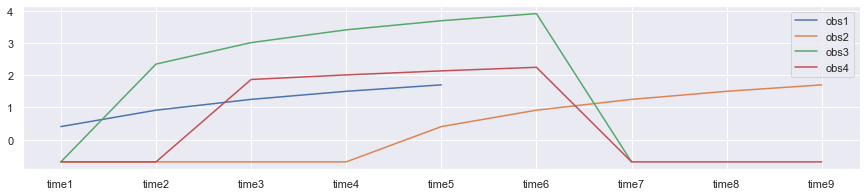

In [2]:
from tslearn.utils import to_time_series_dataset
sample = np.array([[1,2,3,4,5], [0,0,0,0,1,2,3,4,5], [0,10,20,30,40,50,0], [0,0,6,7,8,9,0,0,0]])
X = to_time_series_dataset(sample)
print(f'원자료의 크기와 차원 : {X.shape}')
df = pd.DataFrame(X[:,:,0], index=['obs'+str(i+1) for i in range(len(X))],
                   columns= ['time'+str(i+1) for i in range(X.shape[1])])
df
np.log(0.5 + df).T.plot(figsize=(15,3))

## 1. K-means (유클리디언거리)
### 표준화 전

In [3]:
from sklearn.cluster import KMeans
data = df.fillna(0).copy()
KMeans(n_clusters=2).fit_predict(data)
KMeans(n_clusters=2).fit_transform(data)

array([0, 0, 1, 0])

array([[68.95650803,  4.63081466],
       [72.62919523,  7.83865068],
       [ 0.        , 66.86138231],
       [59.41380311,  8.11035004]])

표준화 (시간 기준_by features)

In [4]:
from sklearn import preprocessing
data_std = preprocessing.StandardScaler().fit_transform(data)
KMeans(n_clusters=2).fit_predict(data_std)
KMeans(n_clusters=2).fit_transform(data_std)

array([0, 0, 1, 0])

array([[2.07038661e+00, 5.48891938e+00],
       [2.83629990e+00, 6.87073337e+00],
       [5.28172195e+00, 4.21468485e-08],
       [1.65724533e+00, 4.62948239e+00]])

표준화 (관측치 기준_by instance)

In [5]:
data_std = preprocessing.StandardScaler().fit_transform(data.T).T
KMeans(n_clusters=2).fit_predict(data_std)

array([1, 0, 1, 1])

## 2. K-means (DTW 거리)
### 표준화 전
- nan을 채울 필요 없음

([<matplotlib.lines.Line2D at 0x1da3f6454f0>],)

DTW알고리즘의 유사도(거리): 0.0


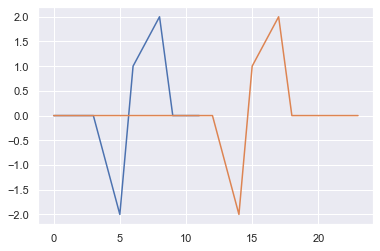

In [6]:
from tslearn import metrics
s1 = [0, 0, 0, 0, -1, -2, 1, 1.5, 2, 0, 0, 0]
s2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -2, 1, 1.5, 2, 0, 0, 0, 0, 0, 0]
plt.plot(s1); plt.plot(s2),
print(f'DTW알고리즘의 유사도(거리): {metrics.dtw(s1, s2)}')

In [7]:
data

,time1,time2,time3,time4,time5,time6,time7,time8,time9
obs1,1.0,2.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0
obs2,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,5.0
obs3,0.0,10.0,20.0,30.0,40.0,50.0,0.0,0.0,0.0
obs4,0.0,0.0,6.0,7.0,8.0,9.0,0.0,0.0,0.0


In [8]:
df

,time1,time2,time3,time4,time5,time6,time7,time8,time9
obs1,1.0,2.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN
obs2,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,5.0
obs3,0.0,10.0,20.0,30.0,40.0,50.0,0.0,NaN,NaN
obs4,0.0,0.0,6.0,7.0,8.0,9.0,0.0,0.0,0.0


In [9]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
df['time_last'] = 0
df['time_first'] = 0
first_column = df.pop('time_first')
df.insert(0, 'time_first', first_column)
df

,time_first,time1,time2,time3,time4,time5,time6,time7,time8,time9,time_last
obs1,0,1.0,2.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,0
obs2,0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,4.0,5.0,0
obs3,0,0.0,10.0,20.0,30.0,40.0,50.0,0.0,NaN,NaN,0
obs4,0,0.0,0.0,6.0,7.0,8.0,9.0,0.0,0.0,0.0,0


### 표준화 (관측치 기준_by instance)

TimeSeriesKMeans(metric='dtw', n_clusters=2)

<AxesSubplot:>

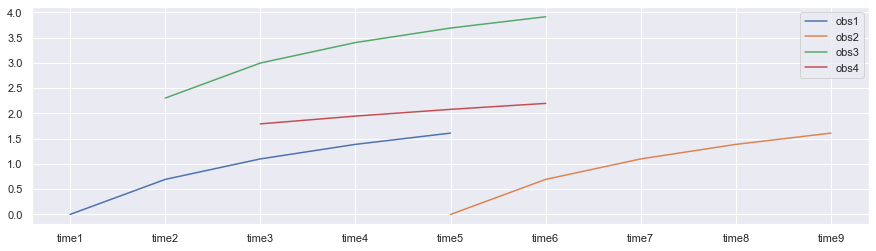

In [10]:
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()
input = minmax.fit_transform(df.fillna(0).T).T
km.fit(input)
df['cluster'] = km.predict(input)
np.log(data.T).plot(figsize=(15,4))

In [11]:
pd.DataFrame(input, index=['obs'+str(i+1) for i in range(len(input))],
                   columns= ['time'+str(i+1) for i in range(input.shape[1])]).round(2)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,time11
obs1,0.0,0.2,0.4,0.60,0.80,1.00,0.0,0.0,0.0,0.0,0.0
obs2,0.0,0.0,0.0,0.00,0.00,0.20,0.4,0.6,0.8,1.0,0.0
obs3,0.0,0.0,0.2,0.40,0.60,0.80,1.0,0.0,0.0,0.0,0.0
obs4,0.0,0.0,0.0,0.67,0.78,0.89,1.0,0.0,0.0,0.0,0.0


TimeSeriesKMeans(metric='dtw', n_clusters=2)

Kmeans-dtw의 silhouette_score: -0.40806935954325385


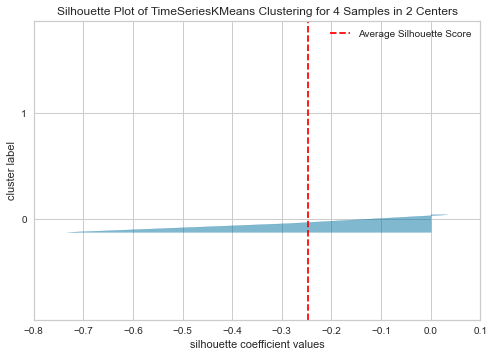

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of TimeSeriesKMeans Clustering for 4 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=TimeSeriesKMeans(metric='dtw', n_clusters=2))

In [12]:
from yellowbrick.cluster import silhouette_visualizer
from tslearn import clustering
km.fit(input)
silhouette_score= clustering.silhouette_score(data, km.predict(input), metric="dtw")
print(f'Kmeans-dtw의 silhouette_score: {silhouette_score}')
silhouette_visualizer(km, np.nan_to_num(input), colors='yellowbrick') # fillna necessary

# End

In [13]:
from tslearn.generators import random_walks
np.random.seed(0)
X = random_walks(n_ts=20, sz=16, d=1)
labels = np.random.randint(2, size=20)
data = pd.DataFrame(np.squeeze(X))
data['labels'] = labels 
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,labels
0,1.764052,2.164210,3.142948,5.383841,7.251399,6.274121,7.224209,7.072852,6.969633,7.380232,7.524275,8.978549,9.739587,9.861262,10.305125,10.638799,0
1,1.494079,1.288921,1.601989,0.747893,-1.805097,-1.151478,-0.287042,-1.029207,1.240547,-0.213818,-0.168060,-0.355244,1.177536,2.646894,2.801842,3.180004,0
2,-0.887786,-2.868582,-3.216494,-3.060145,-1.829855,-0.627475,-1.014802,-1.317104,-2.365657,-3.785675,-5.491946,-3.541170,-4.050822,-4.488897,-5.741692,-4.964202,1
3,-1.613898,-1.826638,-2.722105,-2.335202,-2.846007,-4.026640,-4.054822,-3.626490,-3.559973,-3.257501,-3.891823,-4.254564,-4.927024,-5.286578,-6.099724,-7.826007,1
4,0.177426,-0.224355,-1.854553,-1.391771,-2.299069,-2.247124,-1.518033,-1.389050,-0.249650,-1.484476,-1.082134,-1.766944,-2.637741,-3.216591,-3.528143,-3.471978,1
5,-1.165150,-0.264323,0.201339,-1.334905,0.153348,2.049237,3.228016,3.048092,1.977339,3.031791,2.628614,3.851059,4.059334,5.035973,5.392339,6.098912,1
6,0.010500,1.796371,1.923283,2.325272,4.208423,2.860664,1.590179,2.559575,1.386452,3.330073,2.916454,2.168999,4.091941,5.572456,7.440015,8.346060,1
7,-0.861226,1.048839,0.780836,1.583292,2.530544,2.375534,2.989614,3.911820,4.288246,3.188845,3.487083,4.813469,4.118901,3.969267,3.534113,5.383377,1
8,0.672295,1.079757,0.309841,0.849090,0.174757,0.206588,-0.429258,0.247175,0.823766,0.615467,1.011474,-0.081588,-1.572846,-1.133454,-0.966780,-0.331749,1
9,2.383145,3.327624,2.414802,3.531818,2.215911,1.754326,1.686085,3.399427,2.654673,1.828234,1.729782,1.066303,2.192939,1.113008,-0.034461,-0.472281,1


In [14]:
clustering.silhouette_score(X, labels, metric="dtw")  # doctest: +ELLIPSIS
clustering.silhouette_score(X, labels, metric="euclidean")  # doctest: +ELLIPSIS
clustering.silhouette_score(X, labels, metric="softdtw")  # doctest: +ELLIPSIS
clustering.silhouette_score(X, labels, metric="softdtw", metric_params={"gamma": 2.})
clustering.silhouette_score(metrics.cdist_dtw(X), labels, metric="precomputed")  # doctest: +ELLIPSIS

0.13383800961858022

0.09126917644591379

0.17953934301338687

0.1759106080277656

0.13383800961858022